In [1]:
import psycopg2
# to install from commandline: conda install -c anaconda psycopg2
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

#need to be connected to vpn
import config 
conn = psycopg2.connect(dbname=config.dbname, user=config.user, host=config.host, port=config.port,password=config.password)
cur=conn.cursor()

query_schema = 'SET search_path to ' + "mimiciv" + ';'

In [2]:
# Models/algorithms/classifiers
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation of models
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

In [40]:
oasis = pd.read_csv("first_day_oasis_all.csv") 
#https://github.com/MIT-LCP/mimic-code/blob/main/mimic-iv/concepts/score/oasis.sql
#ran on bigquery using derived tables, exported first 10000 cases
oasis

,subject_id,hadm_id,stay_id,oasis,oasis_prob,age,age_score,preiculos,preiculos_score,gcs,gcs_score,heartrate,heart_rate_score,meanbp,mbp_score,resprate,resp_rate_score,temp,temp_score,urineoutput,urineoutput_score,mechvent,mechvent_score,electivesurgery,electivesurgery_score
0,18329324,24947486,38717050,58,0.772134,52,3,1,5,7.0,10.0,191.0,6.0,54.0,2.0,4.0,10.0,37.39,2.0,760.0,5.0,1,9,0,6
1,19352034,21509557,30058866,52,0.611922,64,6,1,5,3.0,10.0,127.0,6.0,58.0,2.0,8.0,1.0,38.00,2.0,1300.0,5.0,1,9,0,6
2,11958726,24320913,34483718,52,0.611922,75,6,25090,2,3.0,10.0,124.0,3.0,169.0,3.0,38.0,6.0,39.56,2.0,720.0,5.0,1,9,0,6
3,13748756,25103103,34515444,52,0.611922,73,6,1,5,5.0,10.0,98.0,1.0,59.0,2.0,24.0,1.0,36.94,2.0,458.0,10.0,1,9,0,6
4,17957832,21164559,33682689,57,0.748927,67,6,0,5,13.0,4.0,128.0,6.0,146.0,3.0,33.0,6.0,39.40,2.0,238.0,10.0,1,9,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76535,16446574,23154523,37988225,51,0.581248,63,6,1,5,14.0,3.0,148.0,6.0,35.0,3.0,35.0,6.0,37.67,2.0,1067.0,5.0,1,9,0,6
76536,17577224,21249027,31470584,51,0.581248,64,6,80,3,9.0,4.0,118.0,3.0,56.0,2.0,34.0,6.0,37.11,2.0,300.0,10.0,1,9,0,6
76537,14181616,25214071,35677966,51,0.581248,65,6,24,3,8.0,4.0,121.0,3.0,52.0,2.0,36.0,6.0,37.67,2.0,372.0,10.0,1,9,0,6
76538,18191909,23318961,39134783,51,0.581248,91,7,24435,2,14.0,3.0,116.0,3.0,44.0,3.0,37.0,6.0,37.39,2.0,115.0,10.0,1,9,0,6


In [4]:
oasis.shape

(76540, 25)

#from Meghan
Data quality check
I noticed in some of our your output tables that there was a patient that had a preiculos = 20003
The other values looked pretty low. Is this in 'days' as unit? I wonder if this is a good column to do some of the QC-type checks that Garrett spoke about in his lecture

(array([7.6514e+04, 1.8000e+01, 3.0000e+00, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-1.3910000e+03,  1.6897650e+05,  3.3934400e+05,  5.0971150e+05,
         6.8007900e+05,  8.5044650e+05,  1.0208140e+06,  1.1911815e+06,
         1.3615490e+06,  1.5319165e+06,  1.7022840e+06]),
 <BarContainer object of 10 artists>)

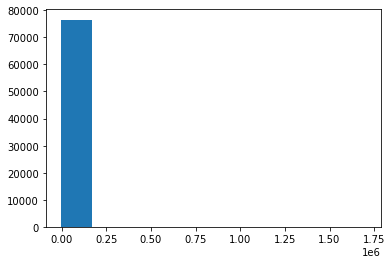

In [147]:
plt.hist(oasis.preiculos) 

#rechecked SQL preiculos is in MINUTES so 
#yeah, 24435 minutes is 16 days so don't need to throw anything out

In [157]:
oasis[oasis['preiculos']>500]

,subject_id,hadm_id,stay_id,oasis,oasis_prob,age,age_score,preiculos,preiculos_score,gcs,gcs_score,heartrate,heart_rate_score,meanbp,mbp_score,resprate,resp_rate_score,temp,temp_score,urineoutput,urineoutput_score,mechvent,mechvent_score,electivesurgery,electivesurgery_score
2,11958726,24320913,34483718,52,0.611922,75,6,25090,2,3.0,10.0,124.0,3.0,169.0,3.0,38.0,6.0,39.56,2.0,720.0,5.0,1,9,0,6
6,11402910,23375177,36422142,53,0.641734,60,6,5582,1,3.0,10.0,120.0,3.0,266.0,3.0,7.0,1.0,35.40,4.0,57.0,10.0,1,9,0,6
9,16731711,23567649,38774055,67,0.914347,78,9,18964,2,7.0,10.0,137.0,6.0,14.0,4.0,46.0,9.0,36.00,2.0,320.0,10.0,1,9,0,6
18,13263248,22811618,39247539,53,0.641734,66,6,23578,2,4.0,10.0,65.5,0.0,75.0,0.0,32.0,6.0,35.50,4.0,230.0,10.0,1,9,0,6
19,13263248,22811618,34092954,53,0.641734,66,6,20449,2,3.0,10.0,65.5,0.0,61.0,2.0,32.5,6.0,38.17,2.0,295.0,10.0,1,9,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76527,16673542,24414524,38658503,51,0.581248,57,6,1174,0,14.0,3.0,128.0,6.0,32.0,3.0,37.0,6.0,36.39,2.0,480.0,10.0,1,9,0,6
76532,17436366,21769291,36027066,51,0.581248,84,9,13132,1,15.0,0.0,140.0,6.0,93.5,0.0,38.5,6.0,35.67,4.0,554.0,10.0,1,9,0,6
76534,16921511,26256759,38746041,51,0.581248,67,6,161536,2,13.0,4.0,130.0,6.0,48.0,3.0,29.0,1.0,34.80,4.0,240.0,10.0,1,9,0,6
76538,18191909,23318961,39134783,51,0.581248,91,7,24435,2,14.0,3.0,116.0,3.0,44.0,3.0,37.0,6.0,37.39,2.0,115.0,10.0,1,9,0,6


Was getting really low mortality like 1% before because was looking at whole admission - need to only look at ICU admissions



In [7]:
sql = query_schema + """
select *
from mimiciv.icustays
limit 10
"""
icu = pd.read_sql_query(sql,conn) 
icu.head()

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,17867402,24528534,31793211,Trauma SICU (TSICU),Trauma SICU (TSICU),2154-03-03 04:11:00,2154-03-04 18:16:56,1.587454
1,14435996,28960964,31983544,Trauma SICU (TSICU),Trauma SICU (TSICU),2150-06-19 17:57:00,2150-06-22 18:33:54,3.025625
2,17609946,27385897,33183475,Trauma SICU (TSICU),Trauma SICU (TSICU),2138-02-05 18:54:00,2138-02-15 12:42:05,9.741725
3,18966770,23483021,34131444,Trauma SICU (TSICU),Trauma SICU (TSICU),2123-10-25 10:35:00,2123-10-25 18:59:47,0.350544
4,12776735,20817525,34547665,Neuro Stepdown,Neuro Stepdown,2200-07-12 00:33:00,2200-07-13 16:44:40,1.674769


In [8]:
sql = query_schema + """
select hadm_id, ethnicity, admittime, dischtime, hospital_expire_flag, admission_location, discharge_location 
from mimiciv.admissions
limit 5
"""
admit = pd.read_sql_query(sql,conn) 
admit

,hadm_id,ethnicity,admittime,dischtime,hospital_expire_flag,admission_location,discharge_location
0,21038362,UNKNOWN,2139-09-26 14:16:00,2139-09-28 11:30:00,0,None,HOME
1,24941086,WHITE,2123-10-07 23:56:00,2123-10-12 11:22:00,0,None,HOME
2,21965160,UNKNOWN,2147-01-14 09:00:00,2147-01-17 14:25:00,0,None,HOME
3,24709883,OTHER,2165-12-27 17:33:00,2165-12-31 21:18:00,0,None,HOME
4,23272159,BLACK/AFRICAN AMERICAN,2122-08-28 08:48:00,2122-08-30 12:32:00,0,None,HOME


In [10]:
sql = query_schema + """
select *
from mimiciv.icustays icu inner join mimiciv.admissions admit on icu.hadm_id = admit.hadm_id
"""
icu = pd.read_sql_query(sql,conn) 
icu.head()

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,edregtime,edouttime,hospital_expire_flag
0,19450100,22972654,30045697,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2118-04-22 21:11:00,2118-04-25 18:54:57,2.905521,19450100,22972654,2118-04-22 20:05:00,2118-04-27 23:33:00,NaT,EW EMER.,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,ENGLISH,SINGLE,WHITE,2118-04-22 17:26:00,2118-04-22 21:11:00,0
1,10724174,25230672,30060744,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2154-07-14 02:16:00,2154-07-16 22:35:09,2.846632,10724174,25230672,2154-07-14 01:57:00,2154-08-07 12:30:00,NaT,EW EMER.,EMERGENCY ROOM,HOME,Medicare,ENGLISH,DIVORCED,WHITE,2154-07-13 13:21:00,2154-07-14 02:16:00,0
2,18777601,23346390,30134663,Neuro Intermediate,Neuro Intermediate,2112-06-14 22:41:26,2112-06-17 15:08:30,2.685463,18777601,23346390,2112-06-14 17:43:00,2112-06-18 13:35:00,NaT,OBSERVATION ADMIT,PHYSICIAN REFERRAL,REHAB,Other,ENGLISH,WIDOWED,BLACK/AFRICAN AMERICAN,2112-06-14 09:45:00,2112-06-15 00:01:00,0
3,19096303,27132265,30136566,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2127-05-09 01:43:00,2127-05-09 17:51:06,0.672292,19096303,27132265,2127-05-01 01:20:00,2127-05-14 15:50:00,NaT,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,HOME HEALTH CARE,Other,ENGLISH,SINGLE,WHITE,NaT,NaT,0
4,18178513,29650808,30200040,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2116-05-15 14:56:05,2116-05-16 17:03:31,1.088495,18178513,29650808,2116-05-15 12:00:00,2116-05-17 11:55:00,NaT,ELECTIVE,PHYSICIAN REFERRAL,HOME,Medicaid,ENGLISH,SINGLE,WHITE,NaT,NaT,0


In [11]:
icu.hospital_expire_flag.value_counts() #okay, much better 8822 died and 67718 lived = 11.5% mortality 

0    67718
1     8822
Name: hospital_expire_flag, dtype: int64

In [7]:
admit.hospital_expire_flag.value_counts() #compared to the total admission mortality that was much lower like 1% that I was calculating previously

0    514390
1      9350
Name: hospital_expire_flag, dtype: int64

In [12]:
icu.dtypes

subject_id                       int64
hadm_id                          int64
stay_id                          int64
first_careunit                  object
last_careunit                   object
intime                  datetime64[ns]
outtime                 datetime64[ns]
los                            float64
subject_id                       int64
hadm_id                          int64
admittime               datetime64[ns]
dischtime               datetime64[ns]
deathtime               datetime64[ns]
admission_type                  object
admission_location              object
discharge_location              object
insurance                       object
language                        object
marital_status                  object
ethnicity                       object
edregtime               datetime64[ns]
edouttime               datetime64[ns]
hospital_expire_flag             int64
dtype: object

In [15]:
icu.discharge_location.value_counts()

HOME HEALTH CARE                18972
HOME                            17947
SKILLED NURSING FACILITY        14114
DIED                             8795
REHAB                            6180
CHRONIC/LONG TERM ACUTE CARE     5605
HOSPICE                          1679
PSYCH FACILITY                    803
AGAINST ADVICE                    680
ACUTE HOSPITAL                    670
OTHER FACILITY                    325
ASSISTED LIVING                    92
HEALTHCARE FACILITY                17
Name: discharge_location, dtype: int64

In [33]:
ethnicity_mortality  = icu[['ethnicity', 'hospital_expire_flag']].groupby('ethnicity').agg({'total_counts': 'sum'})

[["total_counts"]].apply(lambda x: 100*x/x.sum())

 #thank you Meghan for this code 
#hm weird error not sure why not naming it, try just sum 

KeyError: "Column(s) ['total_counts'] do not exist"

In [20]:
icu[['ethnicity', 'hospital_expire_flag']].groupby('ethnicity').agg({'sum'})

,hospital_expire_flag
,sum
ethnicity,
AMERICAN INDIAN/ALASKA NATIVE,15
ASIAN,285
BLACK/AFRICAN AMERICAN,786
HISPANIC/LATINO,245
OTHER,383
UNABLE TO OBTAIN,156
UNKNOWN,1396
WHITE,5556


In [32]:
icu.ethnicity.value_counts()

WHITE                            51801
BLACK/AFRICAN AMERICAN            8338
UNKNOWN                           6722
OTHER                             3495
HISPANIC/LATINO                   2891
ASIAN                             2257
UNABLE TO OBTAIN                   884
AMERICAN INDIAN/ALASKA NATIVE      152
Name: ethnicity, dtype: int64

In [34]:
icu.groupby('ethnicity').hospital_expire_flag.value_counts()
#sorry, easier o do this a silly way - 

ethnicity                      hospital_expire_flag
AMERICAN INDIAN/ALASKA NATIVE  0                         137
                               1                          15
ASIAN                          0                        1972
                               1                         285
BLACK/AFRICAN AMERICAN         0                        7552
                               1                         786
HISPANIC/LATINO                0                        2646
                               1                         245
OTHER                          0                        3112
                               1                         383
UNABLE TO OBTAIN               0                         728
                               1                         156
UNKNOWN                        0                        5326
                               1                        1396
WHITE                          0                       46245
                               1 

In [36]:
icu.groupby('insurance').hospital_expire_flag.value_counts()

insurance  hospital_expire_flag
Medicaid   0                        5292
           1                         548
Medicare   0                       29850
           1                        4752
Other      0                       32576
           1                        3522
Name: hospital_expire_flag, dtype: int64

In [ ]:
		Lived	Died	Percent
Ethnicity	White	46245	5556	0.107256617
	Black/African American	7552	786	0.09426721
	Hispanic/Latino	2646	245	0.084745763
	Asian	1972	285	0.126273815
				
Insurance	Medicaid	5292	548	0.093835616
	Medicare	29850	4752	0.137333102
	Other	32576	3522	0.097567732

In [44]:
death = icu[['stay_id','ethnicity','hospital_expire_flag']]
death

,stay_id,ethnicity,hospital_expire_flag
0,30045697,WHITE,0
1,30060744,WHITE,0
2,30134663,BLACK/AFRICAN AMERICAN,0
3,30136566,WHITE,0
4,30200040,WHITE,0
...,...,...,...
76535,39927972,UNKNOWN,1
76536,39947918,OTHER,0
76537,39949373,WHITE,0
76538,39978206,WHITE,0


In [45]:
death_id_oasis = pd.merge(death, oasis, on = ['stay_id'], how = 'inner') #thanks Meghan for the tip
death_id_oasis

,stay_id,ethnicity,hospital_expire_flag,subject_id,hadm_id,oasis,oasis_prob,age,age_score,preiculos,preiculos_score,gcs,gcs_score,heartrate,heart_rate_score,meanbp,mbp_score,resprate,resp_rate_score,temp,temp_score,urineoutput,urineoutput_score,mechvent,mechvent_score,electivesurgery,electivesurgery_score
0,30045697,WHITE,0,19450100,22972654,36,0.170145,67,6,66,3,15.0,0.0,126.0,6.0,55.0,2.0,47.0,9.0,35.89,4.0,2950.0,0.0,0,0,0,6
1,30060744,WHITE,0,10724174,25230672,27,0.061106,68,6,19,3,8.0,4.0,105.0,1.0,40.0,3.0,30.0,1.0,37.39,2.0,1985.0,1.0,0,0,0,6
2,30134663,BLACK/AFRICAN AMERICAN,0,18777601,23346390,20,0.025967,66,6,298,0,8.0,4.0,93.0,1.0,96.0,0.0,8.0,1.0,37.50,2.0,NaN,NaN,0,0,0,6
3,30136566,WHITE,0,19096303,27132265,24,0.042509,55,6,11543,1,15.0,0.0,94.0,1.0,56.0,2.0,11.0,1.0,37.50,2.0,1275.0,5.0,0,0,0,6
4,30200040,WHITE,0,18178513,29650808,15,0.013897,51,3,176,3,14.0,3.0,64.0,0.0,57.0,2.0,24.0,1.0,37.00,2.0,1975.0,1.0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76535,39927972,UNKNOWN,1,10965894,23403844,22,0.033259,68,6,23552,2,8.0,4.0,100.0,1.0,81.0,0.0,28.0,1.0,37.22,2.0,NaN,NaN,0,0,0,6
76536,39947918,OTHER,0,19155840,22726919,10,0.007394,21,0,310,0,15.0,0.0,108.0,3.0,80.5,0.0,23.0,1.0,36.61,0.0,3575.0,0.0,0,0,0,6
76537,39949373,WHITE,0,14381330,22804177,31,0.097783,78,9,97,3,15.0,0.0,64.0,0.0,21.0,3.0,11.0,1.0,35.56,4.0,870.0,5.0,0,0,0,6
76538,39978206,WHITE,0,19113885,25409746,30,0.087098,84,9,53,3,15.0,0.0,89.0,1.0,198.0,3.0,12.0,1.0,36.28,2.0,1290.0,5.0,0,0,0,6


In [46]:
death_id_oasis.hospital_expire_flag.value_counts()

0    67718
1     8822
Name: hospital_expire_flag, dtype: int64

How does the OASIS score compare with actual hospital mortality? let's make a confusion matrix for everyone - 



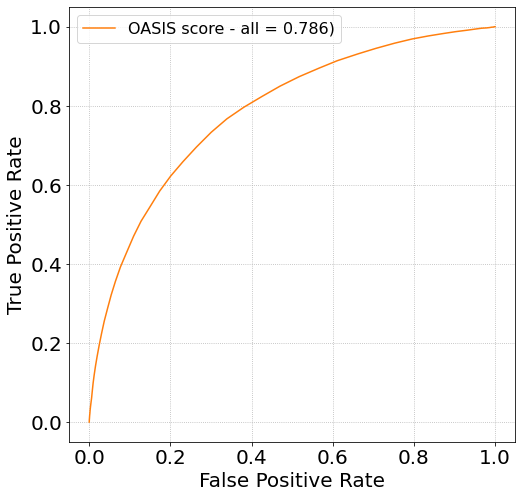

In [90]:
# try again to make sure didn't write something wrong? 
fpr, tpr, _ = roc_curve(death_id_oasis['hospital_expire_flag'], death_id_oasis['oasis_prob'])
auc1 = auc(fpr, tpr)
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(fpr, tpr, color='C1', label="OASIS score - all = "+str(round(auc1, 3))+")")

ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(linestyle=':')
ax.legend(loc='best', fontsize=16)

plt.show()

In [158]:
#all together

y_true = death_id_oasis['hospital_expire_flag'].to_numpy()
y_pred = death_id_oasis['oasis_prob']

n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []
rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(bootstrapped_scores, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(bootstrapped_scores, p))
print('%.3f confidence interval %.3f%% and %.3f%%' % (alpha, lower, upper))

0.950 confidence interval 0.781% and 0.791%


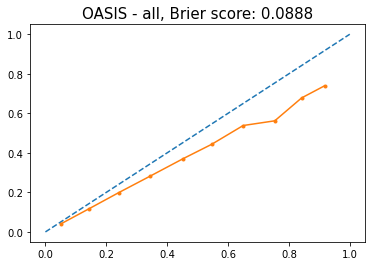

In [168]:
# reliability diagram
fop, mpv = calibration_curve(death_id_oasis['hospital_expire_flag'], death_id_oasis['oasis_prob'], n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')

plt.title('OASIS - all, Brier score: 0.0888', fontsize=15)

plt.show()

In [ ]:


from sklearn.metrics import brier_score_loss, precision_score, recall_score, f1_score


In [165]:
# reliability diagram
fop, mpv = calibration_curve(death_id_oasis['hospital_expire_flag'], death_id_oasis['oasis_prob'], n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')

plt.title('OASIS - all, Brier score: 0.0888', fontsize=15)

plt.show()

print("Brier score OASIS - all: %0.4f" % brier_score_loss(y_true, y_pred))



Brier score RFC: 0.0888


Logistic: f1=0.500 auc=0.440


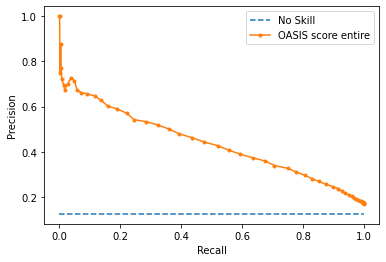

In [256]:
o_precision, o_recall, _ = precision_recall_curve(death_id_oasis['hospital_expire_flag'], death_id_oasis['oasis_prob'])
o_f1, o_auc = f1_score(Y_test, yhat), auc(o_recall, o_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (o_f1, o_auc))
# plot the precision-recall curves
no_skill = len(Y_test[Y_test==1]) / len(Y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(o_recall, o_precision, marker='.', label='OASIS score entire')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [48]:
white = death_id_oasis[death_id_oasis['ethnicity']=='WHITE']

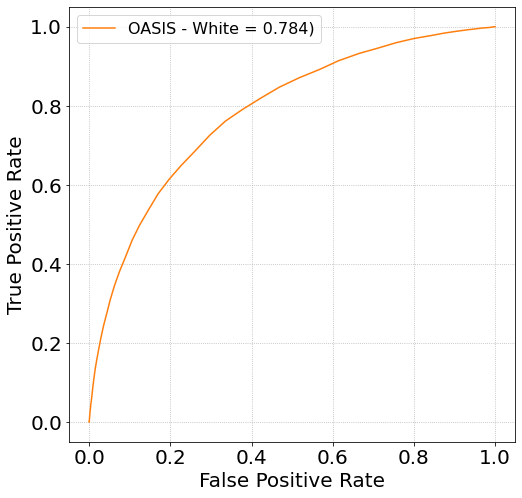

In [94]:
# try again to make sure didn't write something wrong? 
fpr, tpr, _ = roc_curve(white['hospital_expire_flag'], white['oasis_prob'])
auc1 = auc(fpr, tpr)
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(fpr, tpr, color='C1', label="OASIS - White = "+str(round(auc1, 3))+")")

ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(linestyle=':')
ax.legend(loc='best', fontsize=16)

plt.show()

In [143]:
#all together

y_true = white['hospital_expire_flag'].to_numpy()
y_pred = white['oasis_prob'].to_numpy()

n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []
rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(bootstrapped_scores, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(bootstrapped_scores, p))
print('%.3f confidence interval %.3f%% and %.3f%%' % (alpha, lower, upper))

0.950 confidence interval 0.777% and 0.790%


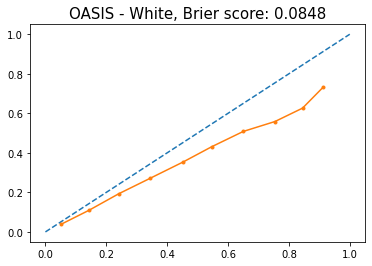

In [171]:
# reliability diagram
fop, mpv = calibration_curve(white['hospital_expire_flag'], white['oasis_prob'], n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')

plt.title('OASIS - White, Brier score: 0.0848', fontsize=15)

plt.show()


print("Brier score OASIS - White: %0.4f" % brier_score_loss(white['hospital_expire_flag'], white['oasis_prob']))



In [170]:


print("Brier score OASIS - White: %0.4f" % brier_score_loss(white['hospital_expire_flag'], white['oasis_prob']))



Brier score OASIS - White: 0.0848


In [50]:
black = death_id_oasis[death_id_oasis['ethnicity']=='BLACK/AFRICAN AMERICAN']

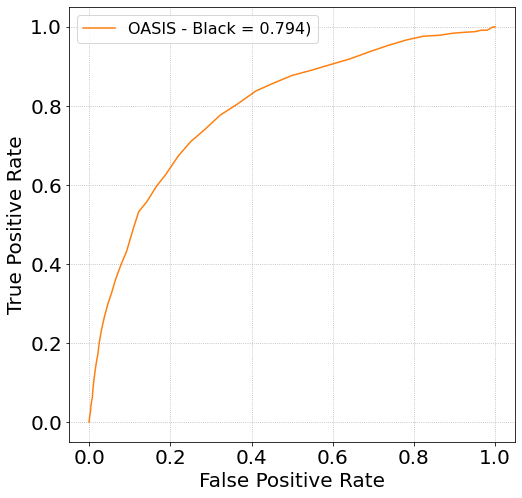

In [95]:
# try again to make sure didn't write something wrong? 
fpr, tpr, _ = roc_curve(black['hospital_expire_flag'], black['oasis_prob'])
auc1 = auc(fpr, tpr)
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(fpr, tpr, color='C1', label="OASIS - Black = "+str(round(auc1, 3))+")")

ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(linestyle=':')
ax.legend(loc='best', fontsize=16)

plt.show()

In [144]:
#all together

y_true = black['hospital_expire_flag'].to_numpy()
y_pred = black['oasis_prob'].to_numpy()

n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []
rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(bootstrapped_scores, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(bootstrapped_scores, p))
print('%.3f confidence interval %.3f%% and %.3f%%' % (alpha, lower, upper))

0.950 confidence interval 0.777% and 0.810%


In [172]:


print("Brier score OASIS - Black: %0.4f" % brier_score_loss(black['hospital_expire_flag'], black['oasis_prob']))



Brier score OASIS - Black: 0.0774


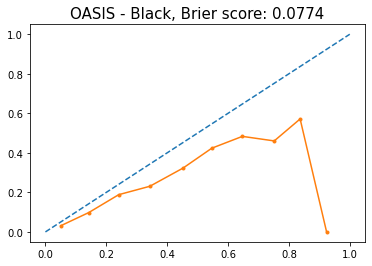

In [173]:
# reliability diagram
fop, mpv = calibration_curve(black['hospital_expire_flag'], black['oasis_prob'], n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')


brierscore = brier_score_loss(black['hospital_expire_flag'], black['oasis_prob']))


plt.title('OASIS - Black, Brier score:' brierscore, fontsize=15)

plt.show()

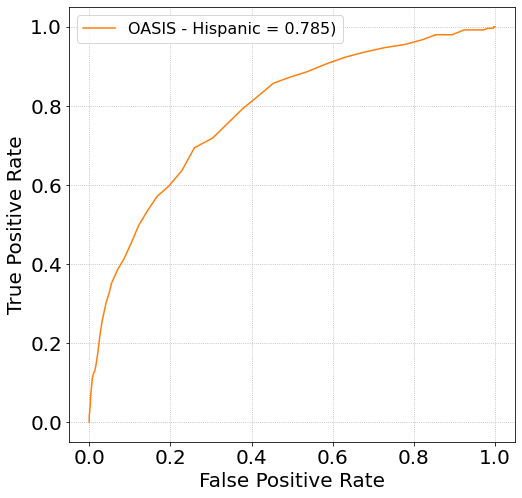

In [96]:
hispanic = death_id_oasis[death_id_oasis['ethnicity']=='HISPANIC/LATINO']
# try again to make sure didn't write something wrong? 
fpr, tpr, _ = roc_curve(hispanic['hospital_expire_flag'], hispanic['oasis_prob'])
auc1 = auc(fpr, tpr)
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(fpr, tpr, color='C1', label="OASIS - Hispanic = "+str(round(auc1, 3))+")")

ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(linestyle=':')
ax.legend(loc='best', fontsize=16)

plt.show()

In [145]:
#all together

y_true = hispanic['hospital_expire_flag'].to_numpy()
y_pred = hispanic['oasis_prob'].to_numpy()

n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []
rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(bootstrapped_scores, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(bootstrapped_scores, p))
print('%.3f confidence interval %.3f%% and %.3f%%' % (alpha, lower, upper))

0.950 confidence interval 0.752% and 0.814%


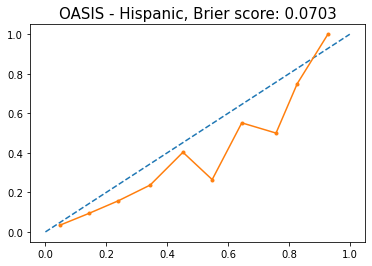

In [178]:
# reliability diagram
fop, mpv = calibration_curve(hispanic['hospital_expire_flag'], hispanic['oasis_prob'], n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')


brierscore = brier_score_loss(hispanic['hospital_expire_flag'], hispanic['oasis_prob'])
plt.title('OASIS - Hispanic, Brier score: ' +str(round(brierscore, 4)), fontsize=15)

plt.show()

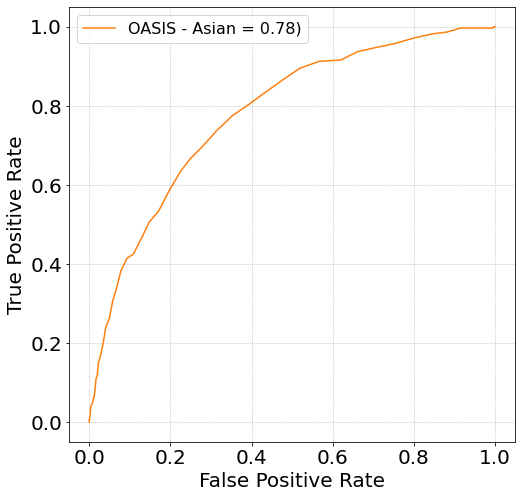

In [97]:
asian = death_id_oasis[death_id_oasis['ethnicity']=='ASIAN']
# try again to make sure didn't write something wrong? 
fpr, tpr, _ = roc_curve(asian['hospital_expire_flag'], asian['oasis_prob'])
auc1 = auc(fpr, tpr)
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(fpr, tpr, color='C1', label="OASIS - Asian = "+str(round(auc1, 3))+")")

ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(linestyle=':')
ax.legend(loc='best', fontsize=16)

plt.show()

In [146]:
#all together

y_true = asian['hospital_expire_flag'].to_numpy()
y_pred = asian['oasis_prob'].to_numpy()

n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []
rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(bootstrapped_scores, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(bootstrapped_scores, p))
print('%.3f confidence interval %.3f%% and %.3f%%' % (alpha, lower, upper))

0.950 confidence interval 0.751% and 0.806%


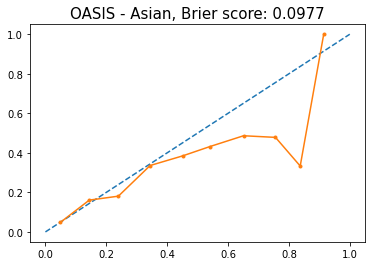

In [180]:
# reliability diagram
fop, mpv = calibration_curve(asian['hospital_expire_flag'], asian['oasis_prob'], n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')


brierscore = brier_score_loss(asian['hospital_expire_flag'], asian['oasis_prob'])


plt.title('OASIS - Asian, Brier score: ' +str(round(brierscore, 4)), fontsize=15)

plt.show()

now, let's run a very simple xgboost model to see if first day's labs can predict mortality
based on https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/ tutorial


In [54]:
death_id_oasis.head()

,stay_id,ethnicity,hospital_expire_flag,subject_id,hadm_id,oasis,oasis_prob,age,age_score,preiculos,preiculos_score,gcs,gcs_score,heartrate,heart_rate_score,meanbp,mbp_score,resprate,resp_rate_score,temp,temp_score,urineoutput,urineoutput_score,mechvent,mechvent_score,electivesurgery,electivesurgery_score
0,30045697,WHITE,0,19450100,22972654,36,0.170145,67,6,66,3,15.0,0.0,126.0,6.0,55.0,2.0,47.0,9.0,35.89,4.0,2950.0,0.0,0,0,0,6
1,30060744,WHITE,0,10724174,25230672,27,0.061106,68,6,19,3,8.0,4.0,105.0,1.0,40.0,3.0,30.0,1.0,37.39,2.0,1985.0,1.0,0,0,0,6
2,30134663,BLACK/AFRICAN AMERICAN,0,18777601,23346390,20,0.025967,66,6,298,0,8.0,4.0,93.0,1.0,96.0,0.0,8.0,1.0,37.50,2.0,NaN,NaN,0,0,0,6
3,30136566,WHITE,0,19096303,27132265,24,0.042509,55,6,11543,1,15.0,0.0,94.0,1.0,56.0,2.0,11.0,1.0,37.50,2.0,1275.0,5.0,0,0,0,6
4,30200040,WHITE,0,18178513,29650808,15,0.013897,51,3,176,3,14.0,3.0,64.0,0.0,57.0,2.0,24.0,1.0,37.00,2.0,1975.0,1.0,0,0,1,0


In [55]:
death_id_oasis['hospital_expire_flag'] #outcome of interest, Y 


0        0
1        0
2        0
3        0
4        0
        ..
76535    1
76536    0
76537    0
76538    0
76539    0
Name: hospital_expire_flag, Length: 76540, dtype: int64

In [56]:
Y=death_id_oasis['hospital_expire_flag']

In [181]:
Y=death_id_oasis['hospital_expire_flag']
columns_to_keep = [
    'age', 'preiculos','gcs','heartrate','meanbp',
    'resprate', 'temp',
       'urineoutput', 'mechvent', 'electivesurgery'
]
X = death_id_oasis[columns_to_keep]

/Users/catgaohow/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:47:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


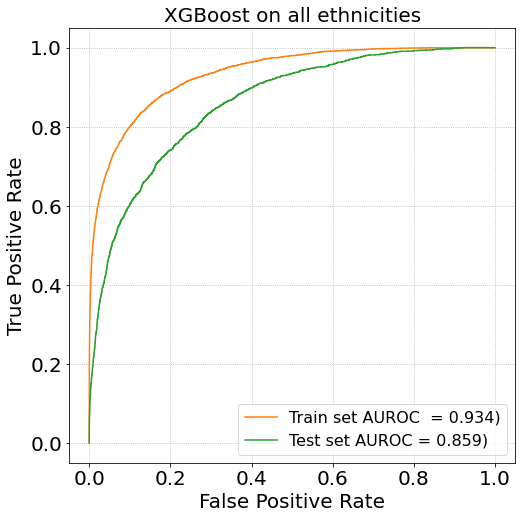

In [182]:
# split data into train and test sets
seed = 7
test_size = 0.20
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
# fit model on training data
model = XGBClassifier()
model.fit(X_train, Y_train)
# make predictions for test data
Y_test_pred = model.predict(X_test)
Y_test_pred_round = [round(value) for value in Y_test_pred]
# Predictions
Y_train_preds = model.predict_proba(X_train)[:,1]
Y_test_preds = model.predict_proba(X_test)[:,1]
# Graphing results
fpr, tpr, _ = roc_curve(Y_test, Y_test_preds)
auc1 = auc(fpr, tpr)
fpr2, tpr2, _ = roc_curve(Y_train, Y_train_preds)
auc2 = auc(fpr2, tpr2)
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(fpr2, tpr2, color='C1', label="Train set AUROC  = "+str(round(auc2, 3))+")")
ax.plot(fpr, tpr, color='C2', label="Test set AUROC = "+str(round(auc1, 3))+")")
ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(linestyle=':')
ax.legend(loc='best', fontsize=16)
ax.set_title('XGBoost on all ethnicities', fontsize=20)

plt.show()

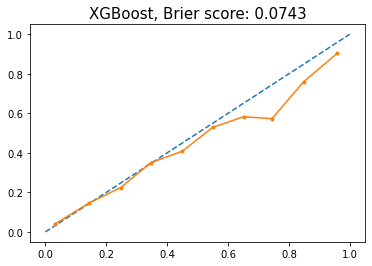

In [183]:
# reliability diagram
fop, mpv = calibration_curve(Y_test, Y_test_preds, n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')

brierscore = brier_score_loss(Y_test, Y_test_preds)
plt.title('XGBoost, Brier score: ' +str(round(brierscore, 4)), fontsize=15)

plt.show()

In [85]:
import numpy as np
from scipy.stats import sem
from sklearn.metrics import roc_auc_score

y_true = Y_test
y_pred = Y_test_preds

print("Original ROC area: {:0.3f}".format(roc_auc_score(y_true, y_pred)))


Original ROC area: 0.859


In [115]:
y_true = Y_test
y_pred = Y_test_preds
y_true2 = y_true.to_numpy()
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []
rng = np.random.RandomState(rng_seed)
y_true2 = y_true.to_numpy()
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    score = roc_auc_score(y_true2[indices], y_pred[indices])
    bootstrapped_scores.append(score)

(array([  1.,  10.,  37., 120., 198., 282., 215.,  92.,  41.,   4.]),
 array([0.84192601, 0.84512674, 0.84832747, 0.8515282 , 0.85472894,
        0.85792967, 0.8611304 , 0.86433113, 0.86753186, 0.8707326 ,
        0.87393333]),
 <BarContainer object of 10 artists>)

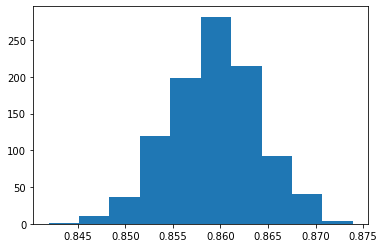

In [125]:
plt.hist(bootstrapped_scores)

In [127]:
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(bootstrapped_scores, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(bootstrapped_scores, p))
print('%.2f confidence interval %.3f%% and %.3f%%' % (alpha, lower, upper))

0.95 confidence interval 0.850% and 0.868%


In [128]:
#all together

y_true = Y_test.to_numpy()
y_pred = Y_test_preds

n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []
rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(bootstrapped_scores, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(bootstrapped_scores, p))
print('%.3f confidence interval %.3f%% and %.3f%%' % (alpha, lower, upper))

0.950 confidence interval 0.850% and 0.868%


In [184]:
Y=white['hospital_expire_flag']
columns_to_keep = [
    'age', 'preiculos','gcs','heartrate','meanbp',
    'resprate', 'temp',
       'urineoutput', 'mechvent', 'electivesurgery'
]
X = white[columns_to_keep]

/Users/catgaohow/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:50:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


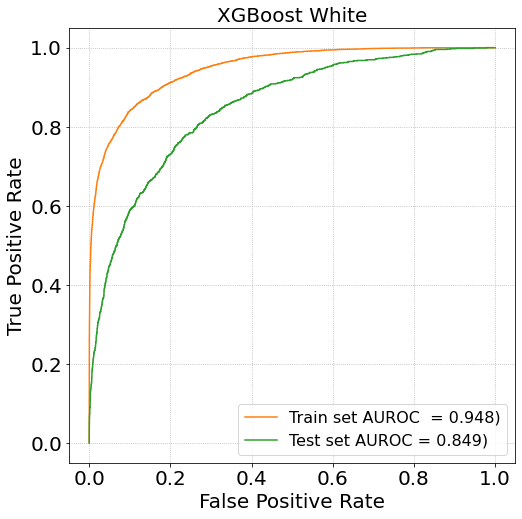

In [188]:
# split data into train and test sets
seed = 7
test_size = 0.20
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
# fit model on training data
model = XGBClassifier()
model.fit(X_train, Y_train)
# make predictions for test data
Y_test_pred = model.predict(X_test)
Y_test_pred_round = [round(value) for value in Y_test_pred]
# Predictions
Y_train_preds = model.predict_proba(X_train)[:,1]
Y_test_preds = model.predict_proba(X_test)[:,1]
# Graphing results
fpr, tpr, _ = roc_curve(Y_test, Y_test_preds)
auc1 = auc(fpr, tpr)
fpr2, tpr2, _ = roc_curve(Y_train, Y_train_preds)
auc2 = auc(fpr2, tpr2)
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(fpr2, tpr2, color='C1', label="Train set AUROC  = "+str(round(auc2, 3))+")")
ax.plot(fpr, tpr, color='C2', label="Test set AUROC = "+str(round(auc1, 3))+")")
ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(linestyle=':')
ax.legend(loc='best', fontsize=16)
ax.set_title('XGBoost White', fontsize=20)

plt.show()

In [131]:
#all together

y_true = Y_test.to_numpy()
y_pred = Y_test_preds

n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []
rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(bootstrapped_scores, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(bootstrapped_scores, p))
print('%.3f confidence interval %.3f%% and %.3f%%' % (alpha, lower, upper))

0.950 confidence interval 0.837% and 0.861%


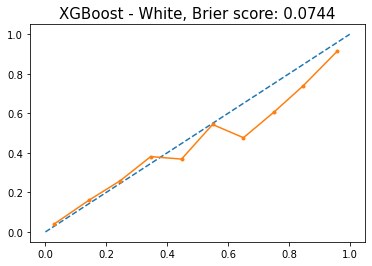

In [186]:
# reliability diagram
fop, mpv = calibration_curve(Y_test, Y_test_preds, n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')

brierscore = brier_score_loss(Y_test, Y_test_preds)
plt.title('XGBoost - White, Brier score: ' +str(round(brierscore, 4)), fontsize=15)

plt.show()

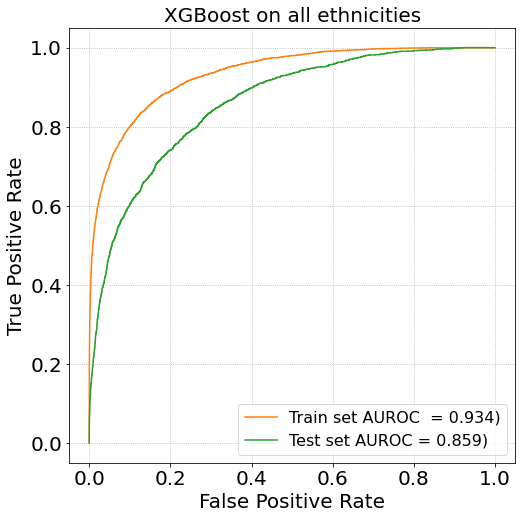

In [63]:
# Graphing results
fpr, tpr, _ = roc_curve(Y_test, Y_test_preds)
auc1 = auc(fpr, tpr)

fpr2, tpr2, _ = roc_curve(Y_train, Y_train_preds)
auc2 = auc(fpr2, tpr2)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(fpr2, tpr2, color='C1', label="Train set AUROC  = "+str(round(auc2, 3))+")")

ax.plot(fpr, tpr, color='C2', label="Test set AUROC = "+str(round(auc1, 3))+")")

ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(linestyle=':')
ax.legend(loc='best', fontsize=16)
ax.set_title('XGBoost on all ethnicities', fontsize=20)

plt.show()

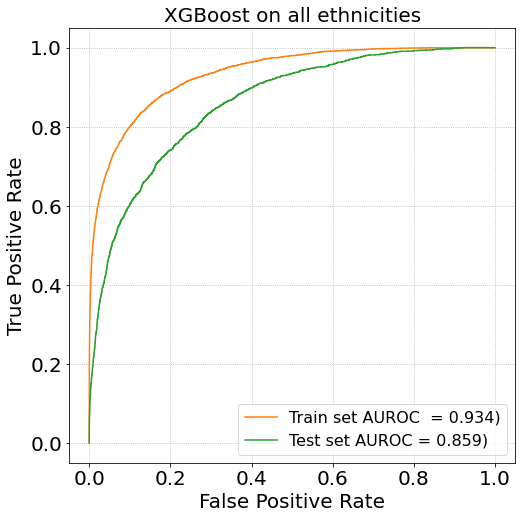

In [63]:
# Graphing results
fpr, tpr, _ = roc_curve(Y_test, Y_test_preds)
auc1 = auc(fpr, tpr)

fpr2, tpr2, _ = roc_curve(Y_train, Y_train_preds)
auc2 = auc(fpr2, tpr2)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(fpr2, tpr2, color='C1', label="Train set AUROC  = "+str(round(auc2, 3))+")")

ax.plot(fpr, tpr, color='C2', label="Test set AUROC = "+str(round(auc1, 3))+")")

ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(linestyle=':')
ax.legend(loc='best', fontsize=16)
ax.set_title('XGBoost on all ethnicities', fontsize=20)

plt.show()

In [ ]:
black.head()

,hadm_id,stay_id,ethnicity,hospital_expire_flag,subject_id,oasis,oasis_prob,age,age_score,preiculos,preiculos_score,gcs,gcs_score,heartrate,heart_rate_score,meanbp,mbp_score,resprate,resp_rate_score,temp,temp_score,urineoutput,urineoutput_score,mechvent,mechvent_score,electivesurgery,electivesurgery_score,rounded_oasis
2,22177535,35370343,BLACK/AFRICAN AMERICAN,0,10390732,20,0.025967,52,3,20003,2,14.0,3.0,113.0,3.0,94.5,0.0,28.0,1.0,37.50,2.0,2845.0,0.0,0,0,0,6,0.0
3,22177535,33180725,BLACK/AFRICAN AMERICAN,0,10390732,31,0.097783,52,3,1,5,8.0,4.0,76.0,0.0,96.0,0.0,5.0,10.0,36.89,2.0,1738.0,1.0,0,0,0,6,0.0
12,25117369,30020731,BLACK/AFRICAN AMERICAN,0,10836215,28,0.068843,64,6,151,3,15.0,0.0,76.0,0.0,91.5,0.0,26.0,1.0,37.06,2.0,300.0,10.0,0,0,0,6,0.0
16,22577891,30031116,BLACK/AFRICAN AMERICAN,0,18874154,33,0.122701,67,6,289,3,14.0,3.0,111.0,3.0,46.0,3.0,35.0,6.0,36.33,2.0,1545.0,1.0,0,0,0,6,0.0
18,26794760,30042091,BLACK/AFRICAN AMERICAN,0,13103745,21,0.029395,66,6,1379,0,15.0,0.0,100.0,1.0,89.5,0.0,27.0,1.0,37.00,2.0,1050.0,5.0,0,0,0,6,0.0


In [189]:
Y=black['hospital_expire_flag']
columns_to_keep = [
    'age', 'preiculos','gcs','heartrate','meanbp',
    'resprate', 'temp',
       'urineoutput', 'mechvent', 'electivesurgery'
]
X = black[columns_to_keep]

/Users/catgaohow/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:02:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


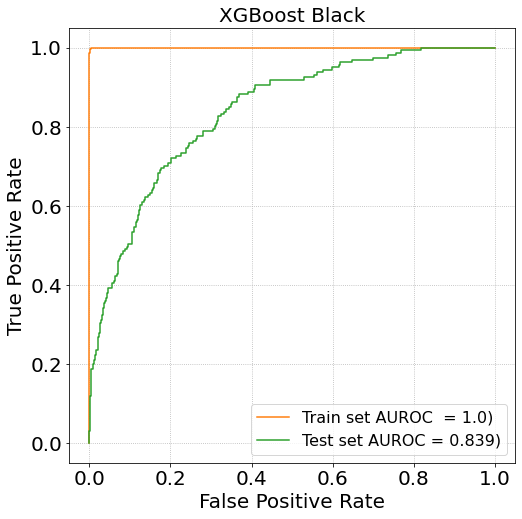

In [192]:
# split data into train and test sets
seed = 7
test_size = 0.20
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
# fit model on training data
model = XGBClassifier()
model.fit(X_train, Y_train)
# make predictions for test data
Y_test_pred = model.predict(X_test)
Y_test_pred_round = [round(value) for value in Y_test_pred]
# Predictions
Y_train_preds = model.predict_proba(X_train)[:,1]
Y_test_preds = model.predict_proba(X_test)[:,1]
# Graphing results
fpr, tpr, _ = roc_curve(Y_test, Y_test_preds)
auc1 = auc(fpr, tpr)
fpr2, tpr2, _ = roc_curve(Y_train, Y_train_preds)
auc2 = auc(fpr2, tpr2)
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(fpr2, tpr2, color='C1', label="Train set AUROC  = "+str(round(auc2, 3))+")")
ax.plot(fpr, tpr, color='C2', label="Test set AUROC = "+str(round(auc1, 3))+")")
ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(linestyle=':')
ax.legend(loc='best', fontsize=16)
ax.set_title('XGBoost Black', fontsize=20)

plt.show()

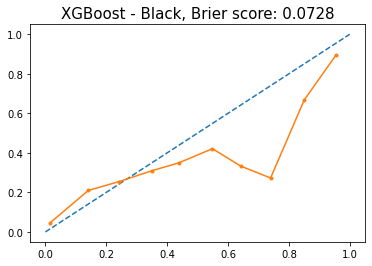

In [191]:
# reliability diagram
fop, mpv = calibration_curve(Y_test, Y_test_preds, n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')

brierscore = brier_score_loss(Y_test, Y_test_preds)
plt.title('XGBoost - Black, Brier score: ' +str(round(brierscore, 4)), fontsize=15)

plt.show()

In [134]:
#all together

y_true = Y_test.to_numpy()
y_pred = Y_test_preds

n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []
rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(bootstrapped_scores, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(bootstrapped_scores, p))
print('%.3f confidence interval %.3f%% and %.3f%%' % (alpha, lower, upper))

0.950 confidence interval 0.807% and 0.867%


In [193]:
Y=hispanic['hospital_expire_flag']
columns_to_keep = [
    'age', 'preiculos','gcs','heartrate','meanbp',
    'resprate', 'temp',
       'urineoutput', 'mechvent', 'electivesurgery'
]
X = hispanic[columns_to_keep]

/Users/catgaohow/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:04:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


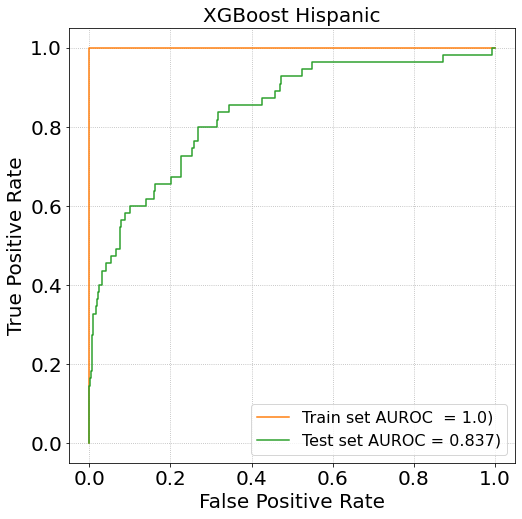

In [195]:
# split data into train and test sets
seed = 7
test_size = 0.20
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
# fit model on training data
model = XGBClassifier()
model.fit(X_train, Y_train)
# make predictions for test data
Y_test_pred = model.predict(X_test)
Y_test_pred_round = [round(value) for value in Y_test_pred]
# Predictions
Y_train_preds = model.predict_proba(X_train)[:,1]
Y_test_preds = model.predict_proba(X_test)[:,1]
# Graphing results
fpr, tpr, _ = roc_curve(Y_test, Y_test_preds)
auc1 = auc(fpr, tpr)
fpr2, tpr2, _ = roc_curve(Y_train, Y_train_preds)
auc2 = auc(fpr2, tpr2)
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(fpr2, tpr2, color='C1', label="Train set AUROC  = "+str(round(auc2, 3))+")")
ax.plot(fpr, tpr, color='C2', label="Test set AUROC = "+str(round(auc1, 3))+")")
ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(linestyle=':')
ax.legend(loc='best', fontsize=16)
ax.set_title('XGBoost Hispanic', fontsize=20)

plt.show()

#why is the train so sharp? 

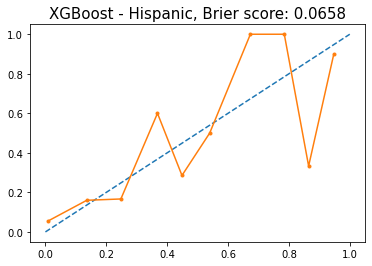

In [196]:
# reliability diagram
fop, mpv = calibration_curve(Y_test, Y_test_preds, n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')

brierscore = brier_score_loss(Y_test, Y_test_preds)
plt.title('XGBoost - Hispanic, Brier score: ' +str(round(brierscore, 4)), fontsize=15)

plt.show()

In [137]:
#all together

y_true = Y_test.to_numpy()
y_pred = Y_test_preds

n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []
rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(bootstrapped_scores, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(bootstrapped_scores, p))
print('%.3f confidence interval %.3f%% and %.3f%%' % (alpha, lower, upper))

0.950 confidence interval 0.767% and 0.896%


In [197]:
Y=asian['hospital_expire_flag']
columns_to_keep = [
    'age', 'preiculos','gcs','heartrate','meanbp',
    'resprate', 'temp',
       'urineoutput', 'mechvent', 'electivesurgery'
]
X = asian[columns_to_keep]

/Users/catgaohow/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:05:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


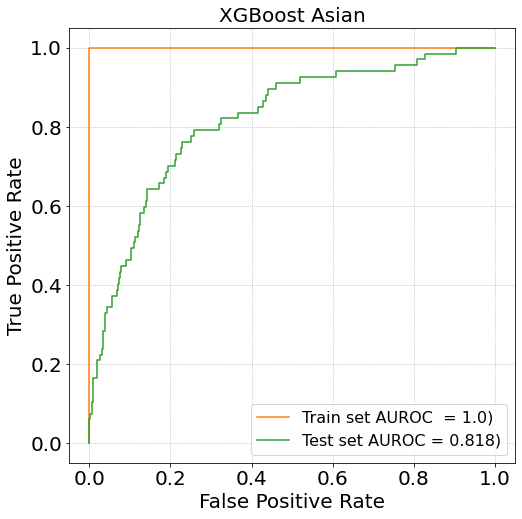

In [198]:
# split data into train and test sets
seed = 7
test_size = 0.20
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
# fit model on training data
model = XGBClassifier()
model.fit(X_train, Y_train)
# make predictions for test data
Y_test_pred = model.predict(X_test)
Y_test_pred_round = [round(value) for value in Y_test_pred]
# Predictions
Y_train_preds = model.predict_proba(X_train)[:,1]
Y_test_preds = model.predict_proba(X_test)[:,1]
# Graphing results
fpr, tpr, _ = roc_curve(Y_test, Y_test_preds)
auc1 = auc(fpr, tpr)
fpr2, tpr2, _ = roc_curve(Y_train, Y_train_preds)
auc2 = auc(fpr2, tpr2)
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(fpr2, tpr2, color='C1', label="Train set AUROC  = "+str(round(auc2, 3))+")")
ax.plot(fpr, tpr, color='C2', label="Test set AUROC = "+str(round(auc1, 3))+")")
ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(linestyle=':')
ax.legend(loc='best', fontsize=16)
ax.set_title('XGBoost Asian', fontsize=20)

plt.show()

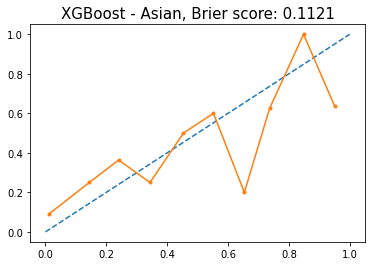

In [199]:
# reliability diagram
fop, mpv = calibration_curve(Y_test, Y_test_preds, n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')

brierscore = brier_score_loss(Y_test, Y_test_preds)
plt.title('XGBoost - Asian, Brier score: ' +str(round(brierscore, 4)), fontsize=15)

plt.show()

In [140]:
#all together

y_true = Y_test.to_numpy()
y_pred = Y_test_preds

n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []
rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(bootstrapped_scores, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(bootstrapped_scores, p))
print('%.3f confidence interval %.3f%% and %.3f%%' % (alpha, lower, upper))

0.950 confidence interval 0.760% and 0.870%
